In [247]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.simplefilter("ignore")
from tqdm import tqdm
import pickle

import statsmodels.api as sm

from fredapi import Fred
api_key = ''
fred = Fred(api_key=api_key)

def drawdown(returns):
    index = (1 + returns).cumprod()
    peaks = index.cummax()
    return (index - peaks) / peaks

In [2]:
url = "https://topforeignstocks.com/wp-content/uploads/2022/01/SP500-Index-Constituents-List-as-of-Jan-1-2022.xlsx"
constituents = pd.read_excel(url)

In [3]:
ls_stocks = list(constituents.Ticker.unique())
ls_stocks = ls_stocks[:-1]

In [5]:
start = pd.to_datetime("2010-01-01")
end = pd.to_datetime("2022-01-22")

stock_dfs = {}
for stock in tqdm(ls_stocks):
    try:
        stock_dfs[stock] = pdr.DataReader(stock, "yahoo", start, end)
    except:
        continue

100%|█████████████████████████████████████████| 505/505 [30:19<00:00,  3.60s/it]


In [8]:
with open('stock_dfs.pickle', 'wb') as handle:
    pickle.dump(stock_dfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('stock_dfs.pickle', 'rb') as handle:
    stock_dfs = pickle.load(handle)

In [12]:
df_prices = pd.DataFrame(columns=list(stock_dfs.keys()))

for stock in stock_dfs.keys():
    df_prices[stock] = stock_dfs[stock]["Adj Close"]

In [125]:
headline_cpi = fred.get_series(series_id="CPIAUCSL")
twoyear = fred.get_series(series_id="DGS2")
bill = fred.get_series(series_id="TB3MS")
note = fred.get_series(series_id="DGS10")
tips = fred.get_series(series_id="DFII10")

<AxesSubplot:xlabel='Date'>

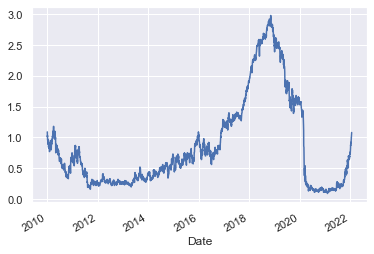

In [509]:
twoyear = twoyear.reindex(df_prices.index, method="pad").ffill()
twoyear.plot()

In [158]:
prices = df_prices.resample("W-FRI").mean()
market = prices.pct_change().mean(axis=1)
market

Date
2010-01-08         NaN
2010-01-15    0.006306
2010-01-22   -0.012993
2010-01-29   -0.028563
2010-02-05   -0.004514
                ...   
2021-12-24    0.001556
2021-12-31    0.028933
2022-01-07   -0.000311
2022-01-14   -0.004637
2022-01-21   -0.036215
Freq: W-FRI, Length: 629, dtype: float64

In [510]:
rate = twoyear.reindex(df_prices.index, method="pad").ffill()
rate = rate.resample("W-FRI").mean().diff()
rate

Date
2010-01-08      NaN
2010-01-15   -0.086
2010-01-22   -0.044
2010-01-29   -0.026
2010-02-05   -0.030
              ...  
2021-12-24    0.021
2021-12-31    0.057
2022-01-07    0.084
2022-01-14    0.102
2022-01-21    0.137
Freq: W-FRI, Length: 629, dtype: float64

In [511]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

In [512]:
BETAS = pd.DataFrame(index=df_prices.columns, columns=["market", "rate"])

for stock in tqdm(df_prices.columns):
    endog = prices[stock].pct_change()
    temp = pd.DataFrame({"market": market, "rate": rate})
    temp = pd.DataFrame(scaler.fit_transform(temp), index=temp.index, columns=temp.columns)
    exog = sm.add_constant(temp)
    model = sm.OLS(endog=endog, exog=exog, missing="drop").fit()
    for b in ["market", "rate"]:
        BETAS.loc[stock, b] = model.tvalues[b]

100%|████████████████████████████████████████| 503/503 [00:01<00:00, 290.09it/s]


<AxesSubplot:xlabel='market', ylabel='rate'>

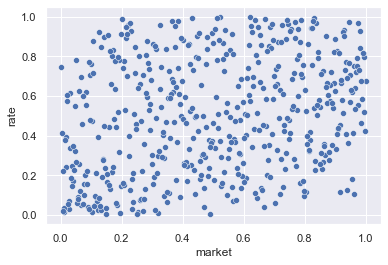

In [513]:
sns.scatterplot(x="market", y="rate", data=BETAS.rank(axis=0, ascending=False)/503)

In [500]:
tickers = {}

tickers["low"] = BETAS.index[(BETAS.rate.rank()/503)<0.2]
tickers["high"] = BETAS.index[(BETAS.rate.rank()/503)>0.8]

duration = pd.DataFrame()
for key in tickers.keys():
    duration[key] = prices[tickers[key]].pct_change().mean(axis=1)
    
(1 + duration).cumprod().plot()
plt.title("Using the yield on the 10 year note")

<AxesSubplot:xlabel='Date'>

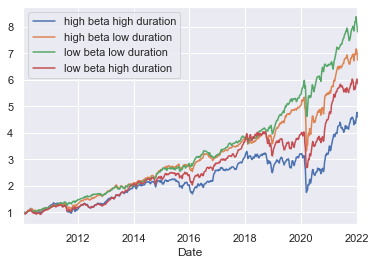

In [514]:
temp = BETAS.rank(axis=0, ascending=True) / 503
twoway_tickers = {
    "high beta high duration": temp.index[np.logical_and(temp.market>0.50, temp.rate>0.75)], 
    "high beta low duration": temp.index[np.logical_and(temp.market>0.50, temp.rate<0.25)], 
    "low beta low duration": temp.index[np.logical_and(temp.market<0.50, temp.rate<0.25)], 
    "low beta high duration": temp.index[np.logical_and(temp.market<0.50, temp.rate>0.75)], 
}

portfolios = pd.DataFrame(columns=list(twoway_tickers.keys()))

for key in twoway_tickers.keys():
    portfolios[key] = prices[twoway_tickers[key]].pct_change().mean(axis=1)
    
(1 + portfolios).cumprod().plot()

2010-01-01 to 2022-01-22


,low,high
Mean [%],15.91,13.79
Volatility [%],11.63,18.46
Sharpe ratio,1.37,0.75
Max Drawdown [%],-30.72,-43.74


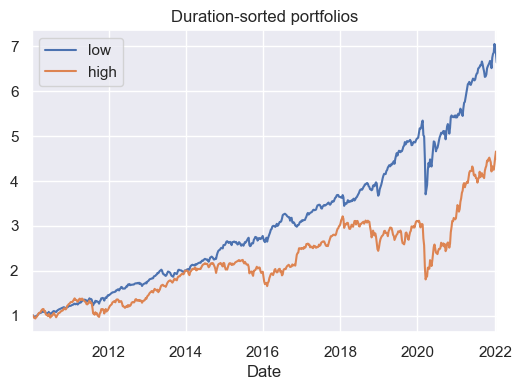

In [515]:
df_summary = pd.DataFrame()

start = "2010-01-01"
end = "2022-01-22"

annual_factor = 252 / 5

temp = duration[start:end]

df_summary = df_summary.append(100 * annual_factor * temp.mean(), ignore_index=True)
df_summary = df_summary.append(100 * np.sqrt(annual_factor) * temp.std(), ignore_index=True)
df_summary = df_summary.append(np.sqrt(annual_factor) * temp.mean() / temp.std(), ignore_index=True)
df_summary = df_summary.append(100 * drawdown(temp).min(), ignore_index=True)

df_summary.index = ['Mean [%]', 'Volatility [%]', 'Sharpe ratio', 'Max Drawdown [%]']

plt.figure(dpi=100)
for col in temp.columns:
    (1 + temp[start:end][col]).cumprod().plot(label=col)
plt.legend()
plt.title("Duration-sorted portfolios")

print(start + " to " + end)
display(np.round(df_summary, 2))

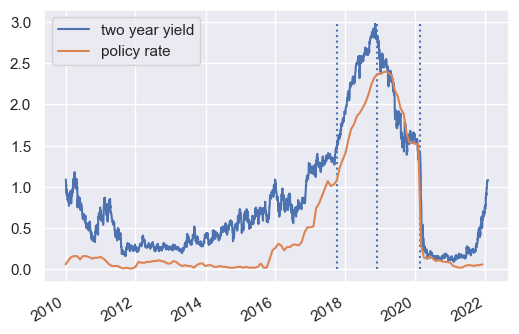

In [462]:
start = "2010-01-01"
end = "2022-02-01"

plt.figure(dpi=100)
twoyear[start:end].ffill().plot(label="two year yield")
bill[start:end].ffill().plot(label="policy rate")
plt.vlines(x=["2017-10-01", "2018-12-01", "2020-02-23"], ymin=0, ymax=3, ls=":")
plt.legend()

In [430]:
years = np.linspace(start=2010, stop=2021, num=12).astype(int)
df_yearRet = {}

for year in years:
    temp = duration[duration.index.year==year]
    df_yearRet[year] = 100 * annual_factor * temp.mean()

df_yearRet = pd.DataFrame.from_dict(
    df_yearRet, 
    orient="index"
)
display(df_yearRet)
print(df_yearRet.mean())
df_yearRet = df_yearRet.melt(ignore_index=False, var_name="Duration", value_name="Return")
df_yearRet.index.name = "year"
df_yearRet = df_yearRet.reset_index()

,low,high
2010,17.668477,19.890021
2011,16.469387,-5.706236
2012,16.843100,19.450376
2013,15.855791,39.491343
2014,22.977628,11.418132
2015,7.449957,-5.389190
2016,13.028903,22.050934
2017,17.014933,19.270761
2018,-0.376505,-19.220576
2019,29.401132,23.670685


low     16.093886
high    13.830806
dtype: float64


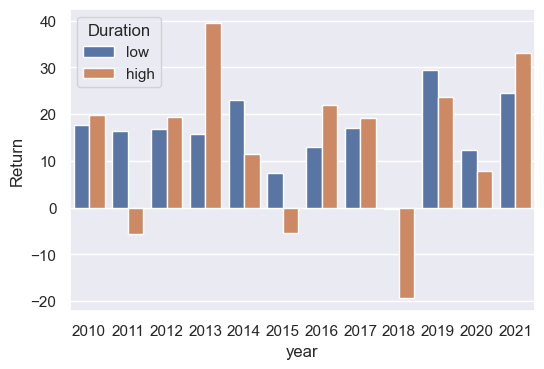

In [431]:
plt.figure(dpi=100)
sns.barplot(x="year", y="Return", hue="Duration", data=df_yearRet)
plt.show()

2010-01-01 to 2022-01-22


,low,high
Mean [%],15.91,13.79
Volatility [%],11.63,18.46
Sharpe ratio,1.37,0.75
Max Drawdown [%],-30.72,-43.74


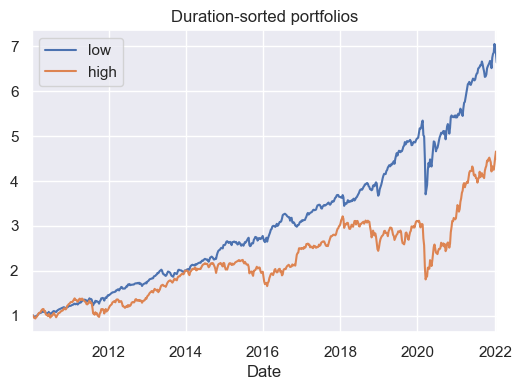

In [516]:
df_summary = pd.DataFrame()

start = "2010-01-01"
end = "2022-01-22"

annual_factor = 252 / 5

temp = duration[start:end]

df_summary = df_summary.append(100 * annual_factor * temp.mean(), ignore_index=True)
df_summary = df_summary.append(100 * np.sqrt(annual_factor) * temp.std(), ignore_index=True)
df_summary = df_summary.append(np.sqrt(annual_factor) * temp.mean() / temp.std(), ignore_index=True)
df_summary = df_summary.append(100 * drawdown(temp).min(), ignore_index=True)

df_summary.index = ['Mean [%]', 'Volatility [%]', 'Sharpe ratio', 'Max Drawdown [%]']

plt.figure(dpi=100)
for col in temp.columns:
    (1 + temp[start:end][col]).cumprod().plot(label=col)
plt.legend()
plt.title("Duration-sorted portfolios")

print(start + " to " + end)
display(np.round(df_summary, 2))

2010-01-01 to 2022-01-21


,high beta high duration,high beta low duration,low beta low duration,low beta high duration
Mean [%],14.08,16.38,17.07,15.42
Volatility [%],18.92,14.13,10.39,15.56
Sharpe ratio,0.74,1.16,1.64,0.99
Max Drawdown [%],-47.03,-37.87,-22.82,-33.62


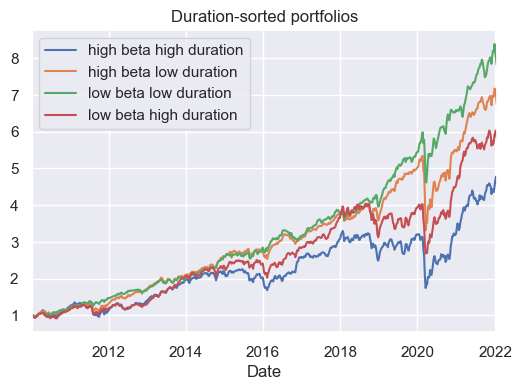

In [517]:
df_summary = pd.DataFrame()

start = "2010-01-01"
end = "2022-01-21"

annual_factor = 252 / 5

temp = portfolios[start:end]

df_summary = df_summary.append(100 * annual_factor * temp.mean(), ignore_index=True)
df_summary = df_summary.append(100 * np.sqrt(annual_factor) * temp.std(), ignore_index=True)
df_summary = df_summary.append(np.sqrt(annual_factor) * temp.mean() / temp.std(), ignore_index=True)
df_summary = df_summary.append(100 * drawdown(temp).min(), ignore_index=True)

df_summary.index = ['Mean [%]', 'Volatility [%]', 'Sharpe ratio', 'Max Drawdown [%]']

plt.figure(dpi=100)
for col in temp.columns:
    (1 + temp[start:end][col]).cumprod().plot(label=col)
plt.legend()
plt.title("Duration-sorted portfolios")

print(start + " to " + end)
display(np.round(df_summary, 2))